# Project Milestone 2

# Left click, Right click : A Safari Through Wikispeedia's Political Jungle

## Import Libraries 

In [1]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
from bs4 import BeautifulSoup 
import os
from Functions import *
import numpy as np

## Download the data and extract it

In [2]:
download_extract_data() #Put the data in the data folder that is ignored to github push

Repository data already exist


./data/wikispeedia_paths-and-graph.tar.gz downloaded
./data/wikispeedia_articles_plaintext.tar.gz downloaded


## Load and Filter of the used data

### Finished and Unfinished Path

In [3]:
PATH_FINISHED="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"

finished_path=pd.read_csv(PATH_FINISHED, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])

finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convert timestamp to datetime


unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convert timestamp to datetime


finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()}  Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07  Last Date 2014-01-15 


### Categories of the articles and Graph

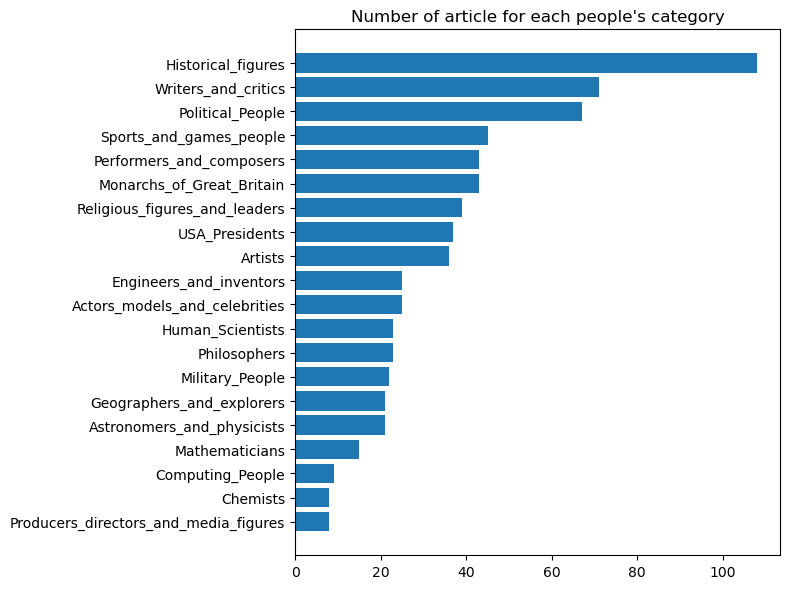

In [4]:
PATH_CATEGORIES = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv"

categories = pd.read_csv(PATH_CATEGORIES, header = 12, delimiter='\t',names=["article","categories"])

categories['article'] = categories['article'].apply(lambda x :(urllib.parse.unquote(x , encoding = 'utf-8'))) # Decode article names

people = categories[categories['categories'].str.contains('subject.People')].copy() # Dataset of people
people['categories'] = people['categories'].apply(lambda x : x[len('subject.People.'):]) # Remove useless string

counts = people.groupby('categories').count()
counts = counts.reset_index()
counts.columns = ["Name", "Count"]
counts=counts.sort_values("Count", ascending=True)

plt.figure(figsize=(8, 6))

plt.barh(counts["Name"], counts['Count'])
plt.title("Number of article for each people's category")
plt.xticks(rotation=0)
plt.tight_layout()

### Plain text

In [5]:
plain_articles=load_plain_article()

## A enlever ? --> oui je pense, pas hyper intéressant comme stat

Longest route in time: 91 pages


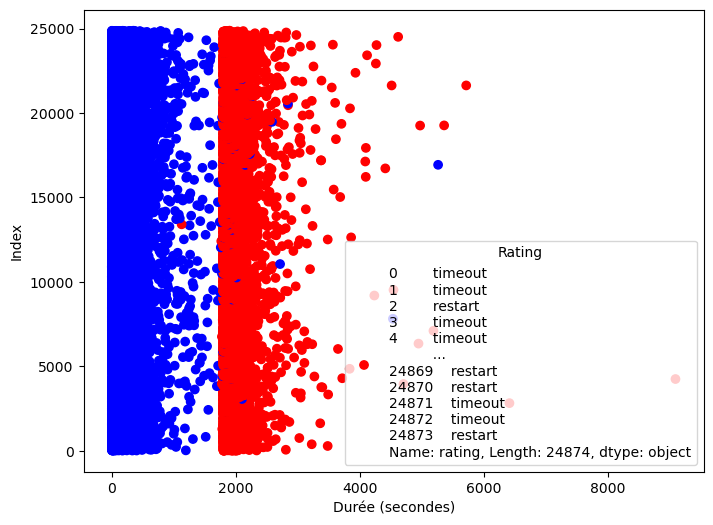

max duration for unfinished_path 151.48333333333332
max duration for finished_path 584.85


In [6]:
unfinished_path_duration = unfinished_path['durationInSec']
unfinished_path_rating = unfinished_path['rating']

max_duration_unfinished = max(unfinished_path_duration)
max_duration_finished = max(finished_path['durationInSec'])

max_duration_finished_id = finished_path.sort_values(by = 'durationInSec', ascending= False)
longest_trip = max_duration_finished_id.iloc[0]
print(f"Longest route in time: {len(longest_trip['path'])} pages")


plt.figure(figsize=(8, 6))
colors = {'timeout': 'red', 'restart': 'blue'}
plt.scatter(unfinished_path_duration, range(len(unfinished_path)), c=[colors[r] for r in unfinished_path_rating], label=unfinished_path_rating)

plt.xlabel('Durée (secondes)')
plt.ylabel('Index')
plt.legend(title='Rating')

plt.show()

print('max duration for unfinished_path', max_duration_unfinished/60)
print('max duration for finished_path', max_duration_finished/60)


# Analyze of the finished path

### Defying hubs, paths and internal path : without the beggining and finishing page

In [7]:
#Concatenate everything into a single character string
all_paths = finished_path['path'].apply(lambda x: x.split(';'))

#Keeping the start and end path and transforming into a dictionnary 
paths_flat = [path for sublist in all_paths for path in sublist]
paths_count = pd.Series(paths_flat).value_counts().to_dict()
paths_count.pop("<") # we remove the backward symbol


#Get rid of the first and last element
internal_paths = all_paths.apply(lambda x: x[1:-1] if len(x) > 2 else [])
internal_paths_flat = [path for sublist in internal_paths for path in sublist]
internal_paths_count = pd.Series(internal_paths_flat).value_counts().to_dict()
internal_paths_count.pop("<")

print(paths_count)

print(internal_paths_count)
# i will now look at the hubs 

{'United_States': 8896, 'Europe': 4362, 'United_Kingdom': 3904, 'England': 3332, 'Earth': 3223, 'Africa': 2796, 'World_War_II': 2301, 'North_America': 1884, 'Germany': 1769, 'Animal': 1713, 'Human': 1642, 'Mammal': 1622, 'France': 1617, 'Computer': 1552, 'Science': 1497, 'English_language': 1430, 'Periodic_table': 1413, 'Brain': 1324, 'Atlantic_Ocean': 1324, 'Telephone': 1252, 'India': 1236, 'Bird': 1210, 'Viking': 1198, 'Agriculture': 1185, 'Plant': 1180, 'Asia': 1176, 'Asteroid': 1174, 'China': 1126, 'Christianity': 1097, 'Japan': 1086, 'United_Nations': 1064, 'Internet': 1047, 'Zebra': 1042, 'Theatre': 1038, 'Russia': 1019, 'Australia': 1003, 'Chemistry': 991, 'London': 976, 'Sun': 932, 'Canada': 922, 'South_America': 920, 'Water': 905, 'European_Union': 891, 'Adolf_Hitler': 883, 'Solar_System': 880, 'Italy': 867, 'President_of_the_United_States': 850, 'Physics': 848, 'Pacific_Ocean': 844, 'Chemical_element': 841, 'Computer_science': 834, 'Biology': 808, 'Mathematics': 805, 'Scotlan

### See if all articles of our dataset are used 

In [8]:
print('Number of articles used in finished path wikispeedia : %d'%(len(paths_count)))
print("Number of articles in the total Dataset : %d"%(len(plain_articles)))

if len(paths_count) != len(plain_articles):
    print("They are %d articles that are not used for the finished paths"%(len(plain_articles)-len(paths_count)))
else:
    print("All articles are used in the finished path of the users")

Number of articles used in finished path wikispeedia : 4169
Number of articles in the total Dataset : 4604
They are 435 articles that are not used for the finished paths


## Graph of the access of used pages for finished paths

why is there whitespace ? --> due to the log 

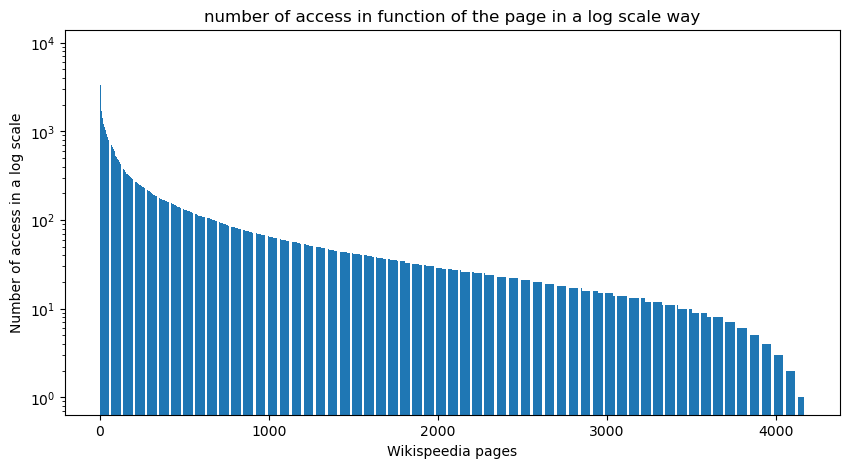

In [9]:
pages = list(paths_count.keys())
counts = list(paths_count.values())

plt.figure(figsize=(10, 5))
plt.bar(range(len(pages)), counts) 
plt.xlabel('Wikispeedia pages')
plt.ylabel('Number of access in a log scale')
plt.yscale('log')
plt.title('number of access in function of the page in a log scale way')
plt.show()

### Top 25 of hubs for finished path

In [10]:
top_25_fin_hubs = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True)[:25])

Text(0.5, 1.0, 'Top 25 pages in path')

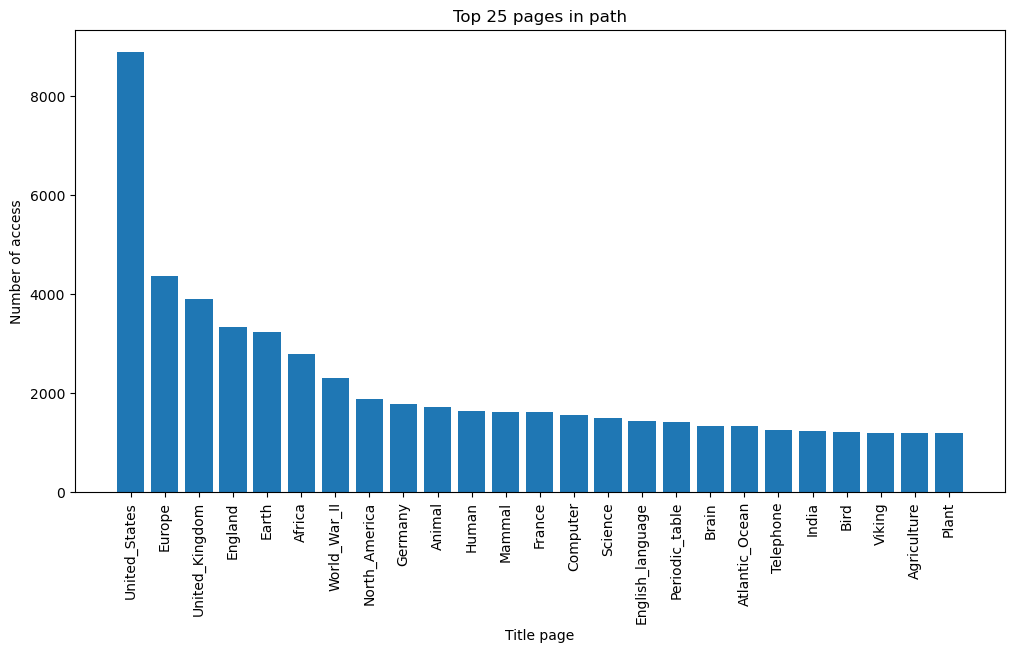

In [11]:
pages = list(top_25_fin_hubs.keys())
counts = list(top_25_fin_hubs.values())
# top 100 c'est trop grand --> top 25

plt.figure(figsize=(12, 6))
plt.bar(pages, counts) 
plt.xlabel('Title page')
plt.ylabel('Number of access')
plt.xticks(rotation=90)
plt.title('Top 25 pages in path')

### Political people representation from the finished pathing of users

In [12]:
#Hubs with all paths for finished one (including start and end articles)
all_hubs = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True))

hubs_people = {key: value for key, value in all_hubs.items() if key in people['article'].tolist()}
hubs_political_people = {key: value for key, value in hubs_people.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

#Hubs with only the pathing for finished one (excluding start and end articles)
all_hubs_internal = dict(sorted(internal_paths_count.items(), key=lambda item: item[1], reverse=True))

hubs_people_internal = {key: value for key, value in all_hubs_internal.items() if key in people['article'].tolist()}
hubs_political_people_internal = {key: value for key, value in hubs_people_internal.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

# MAKE SUBPLOTS would be better !!!

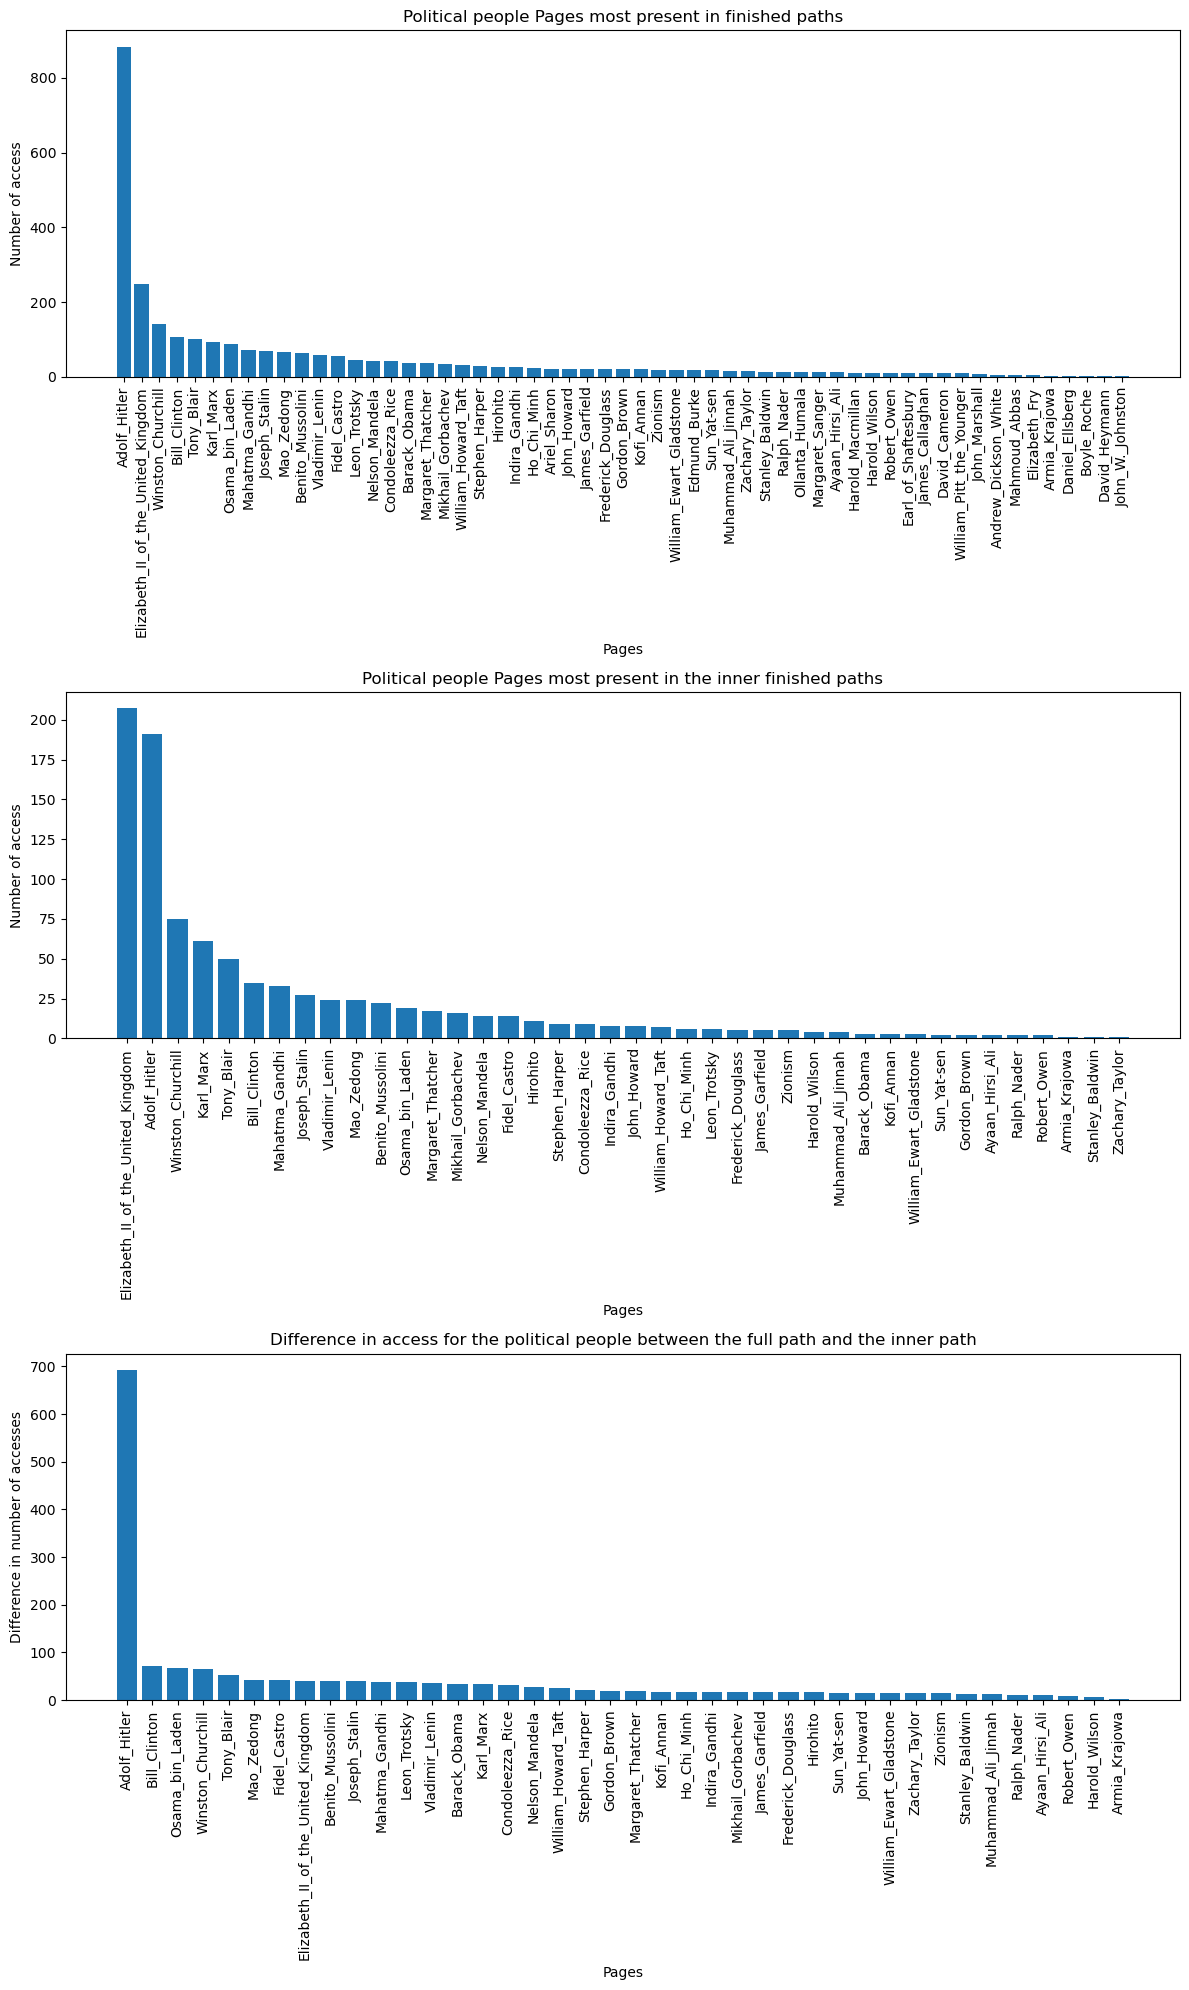

Median difference between the full path and the inner path:  20.0


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# preparation of the data

# full path
pages = list(hubs_political_people.keys())
counts = list(hubs_political_people.values())

# internal path
pages2 = list(hubs_political_people_internal.keys())
counts2 = list(hubs_political_people_internal.values())

# difference between the two sets 
common_keys = set(hubs_political_people.keys()) & set(hubs_political_people_internal.keys())
diff_items = {key: hubs_political_people[key] - hubs_political_people_internal[key] for key in common_keys}
diff_items = dict(sorted(diff_items.items(), key=lambda item: item[1], reverse=True))

diff_values = list(diff_items.values())
median_diff = np.median(diff_values)

# subplots parts
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# Subplot 1: Political people Pages most present in finished paths
axes[0].bar(pages, counts)
axes[0].set_xlabel('Pages')
axes[0].set_ylabel('Number of access')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Political people Pages most present in finished paths')

# Subplot 2: Political people Pages most present in paths without start and end pages
axes[1].bar(pages2, counts2)
axes[1].set_xlabel('Pages')
axes[1].set_ylabel('Number of access')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('Political people Pages most present in the inner finished paths')

# Subplot 3: difference in access between the two sets
axes[2].bar(diff_items.keys(), diff_items.values())
axes[2].set_xlabel('Pages')
axes[2].set_ylabel('Difference in number of accesses')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_title('Difference in access for the political people between the full path and the inner path')

plt.tight_layout()
plt.show()

print('Median difference between the full path and the inner path: ',median_diff)


### Difference of entry/finish between all articles

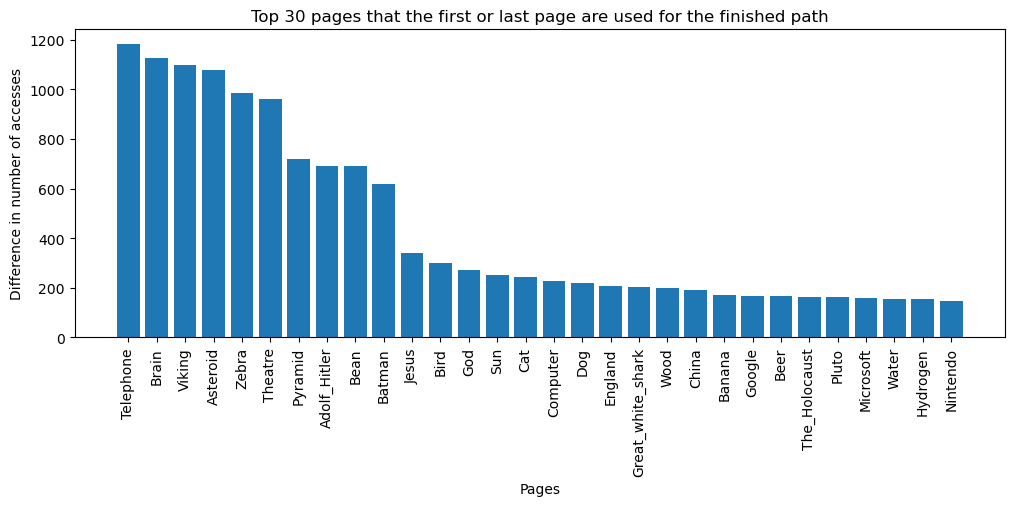

In [14]:
path_diff_dict = {}

#Making a dict that contains the diff in access between the paths and the internal paths
for key in paths_count:
    if key in internal_paths_count:
        path_diff_dict[key] = paths_count[key] - internal_paths_count[key]

sorted_diff = sorted(path_diff_dict.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_diff = dict(sorted_diff[0:30])
plt.figure(figsize=(12, 4))
plt.bar(sorted_diff.keys(), sorted_diff.values())
plt.xlabel('Pages')
plt.ylabel('Difference in number of accesses')
plt.xticks(rotation=90)
plt.title('Top 30 pages that the first or last page are used for the finished path')
plt.show()

## Classification of Political People, defined of political party and wikipedia description, classification by ourself

In [15]:
politicien = pd.read_csv('./political_affiliation.csv', delimiter= ';')
politicien.head(10)

,article,political_affiliation
0,Adolf_Hitler,Right
1,Andrew_Dickson_White,Right
2,Ariel_Sharon,Right
3,Armia_Krajowa,Right
4,Ayaan_Hirsi_Ali,Right
5,Barack_Obama,Left
6,Benito_Mussolini,Right
7,"Benjamin_Disraeli,_1st_Earl_of_Beaconsfield",Center
8,Bill_Clinton,Left
9,Boyle_Roche,Center


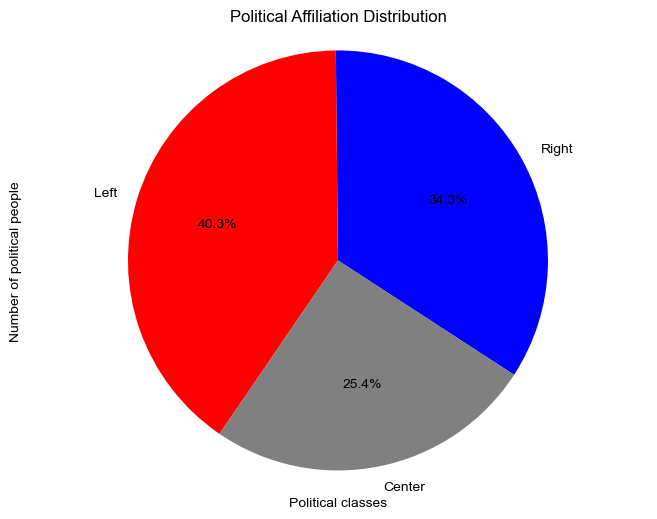

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

affiliation_counts = {"Right": 0, "Left": 0, "Center": 0}

for affiliation in politicien['political_affiliation']:
    if affiliation in affiliation_counts:
        affiliation_counts[affiliation] += 1

labels = list(affiliation_counts.keys())
sizes = list(affiliation_counts.values())
colors = ['blue', 'red', 'gray']

plt.figure(figsize=(8, 6))  
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-33)
plt.xlabel('Political classes')
plt.ylabel('Number of political people')
plt.title('Political Affiliation Distribution')
plt.axis('equal')  
sns.set_context("talk")  
sns.set_style("whitegrid")  
plt.show()


## Classification of all articles on the political bias present in the text 

This classification is explained in the README file and has been made in an other file. Here we are using the result of this Machine Learning prediction model.

In [17]:
bias = pd.read_csv('political_bias.csv')
bias.head(10)
bias["Bias"]= bias["Bias"].replace({0:"left", 1:"center", 2:"right"})

In [18]:
df_categories = categories.copy()
df_categories.head(20)

,article,categories
0,Áedán_mac_Gabráin,subject.People.Historical_figures
1,Åland,subject.Countries
2,Åland,subject.Geography.European_Geography.European_...
3,Édouard_Manet,subject.People.Artists
4,Éire,subject.Countries
5,Éire,subject.Geography.European_Geography.European_...
6,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...
7,Óengus_I_of_the_Picts,subject.People.Historical_figures
8,€2_commemorative_coins,subject.Business_Studies.Currency
9,10th_century,subject.History.General_history


In [19]:
import pandas as pd

# one hot encoding for all of the categories
df_categories['categories'] = df_categories['categories'].str.replace('subject.', '')
encoded_categories = df_categories['categories'].str.get_dummies(sep='.')

# concatenating the article names with the encoded categories
categories_encoded = pd.concat([df_categories['article'], encoded_categories], axis=1)

# combination of all of the categories for each article
categories_combined = categories_encoded.groupby('article').max().reset_index()

categories_combined.head()


,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_events,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# i test just to see for which columns is there a 1 for the article Åland
aland_row = categories_combined[categories_combined['article'] == 'Åland']

columns_with_1 = aland_row.iloc[:, 1:].eq(1).any()

column_names_with_1 = columns_with_1[columns_with_1].index.tolist()
print(column_names_with_1)


['Countries', 'European_Countries', 'European_Geography', 'Geography']


In [21]:
# now i'm merging the categories_combined df with the political bias df 

all_articles_with_bias_and_categories = pd.merge(categories_combined, bias, left_on = 'article', right_on = 'title', how = 'left')
all_articles_with_bias_and_categories = all_articles_with_bias_and_categories.drop('title', axis = 1)


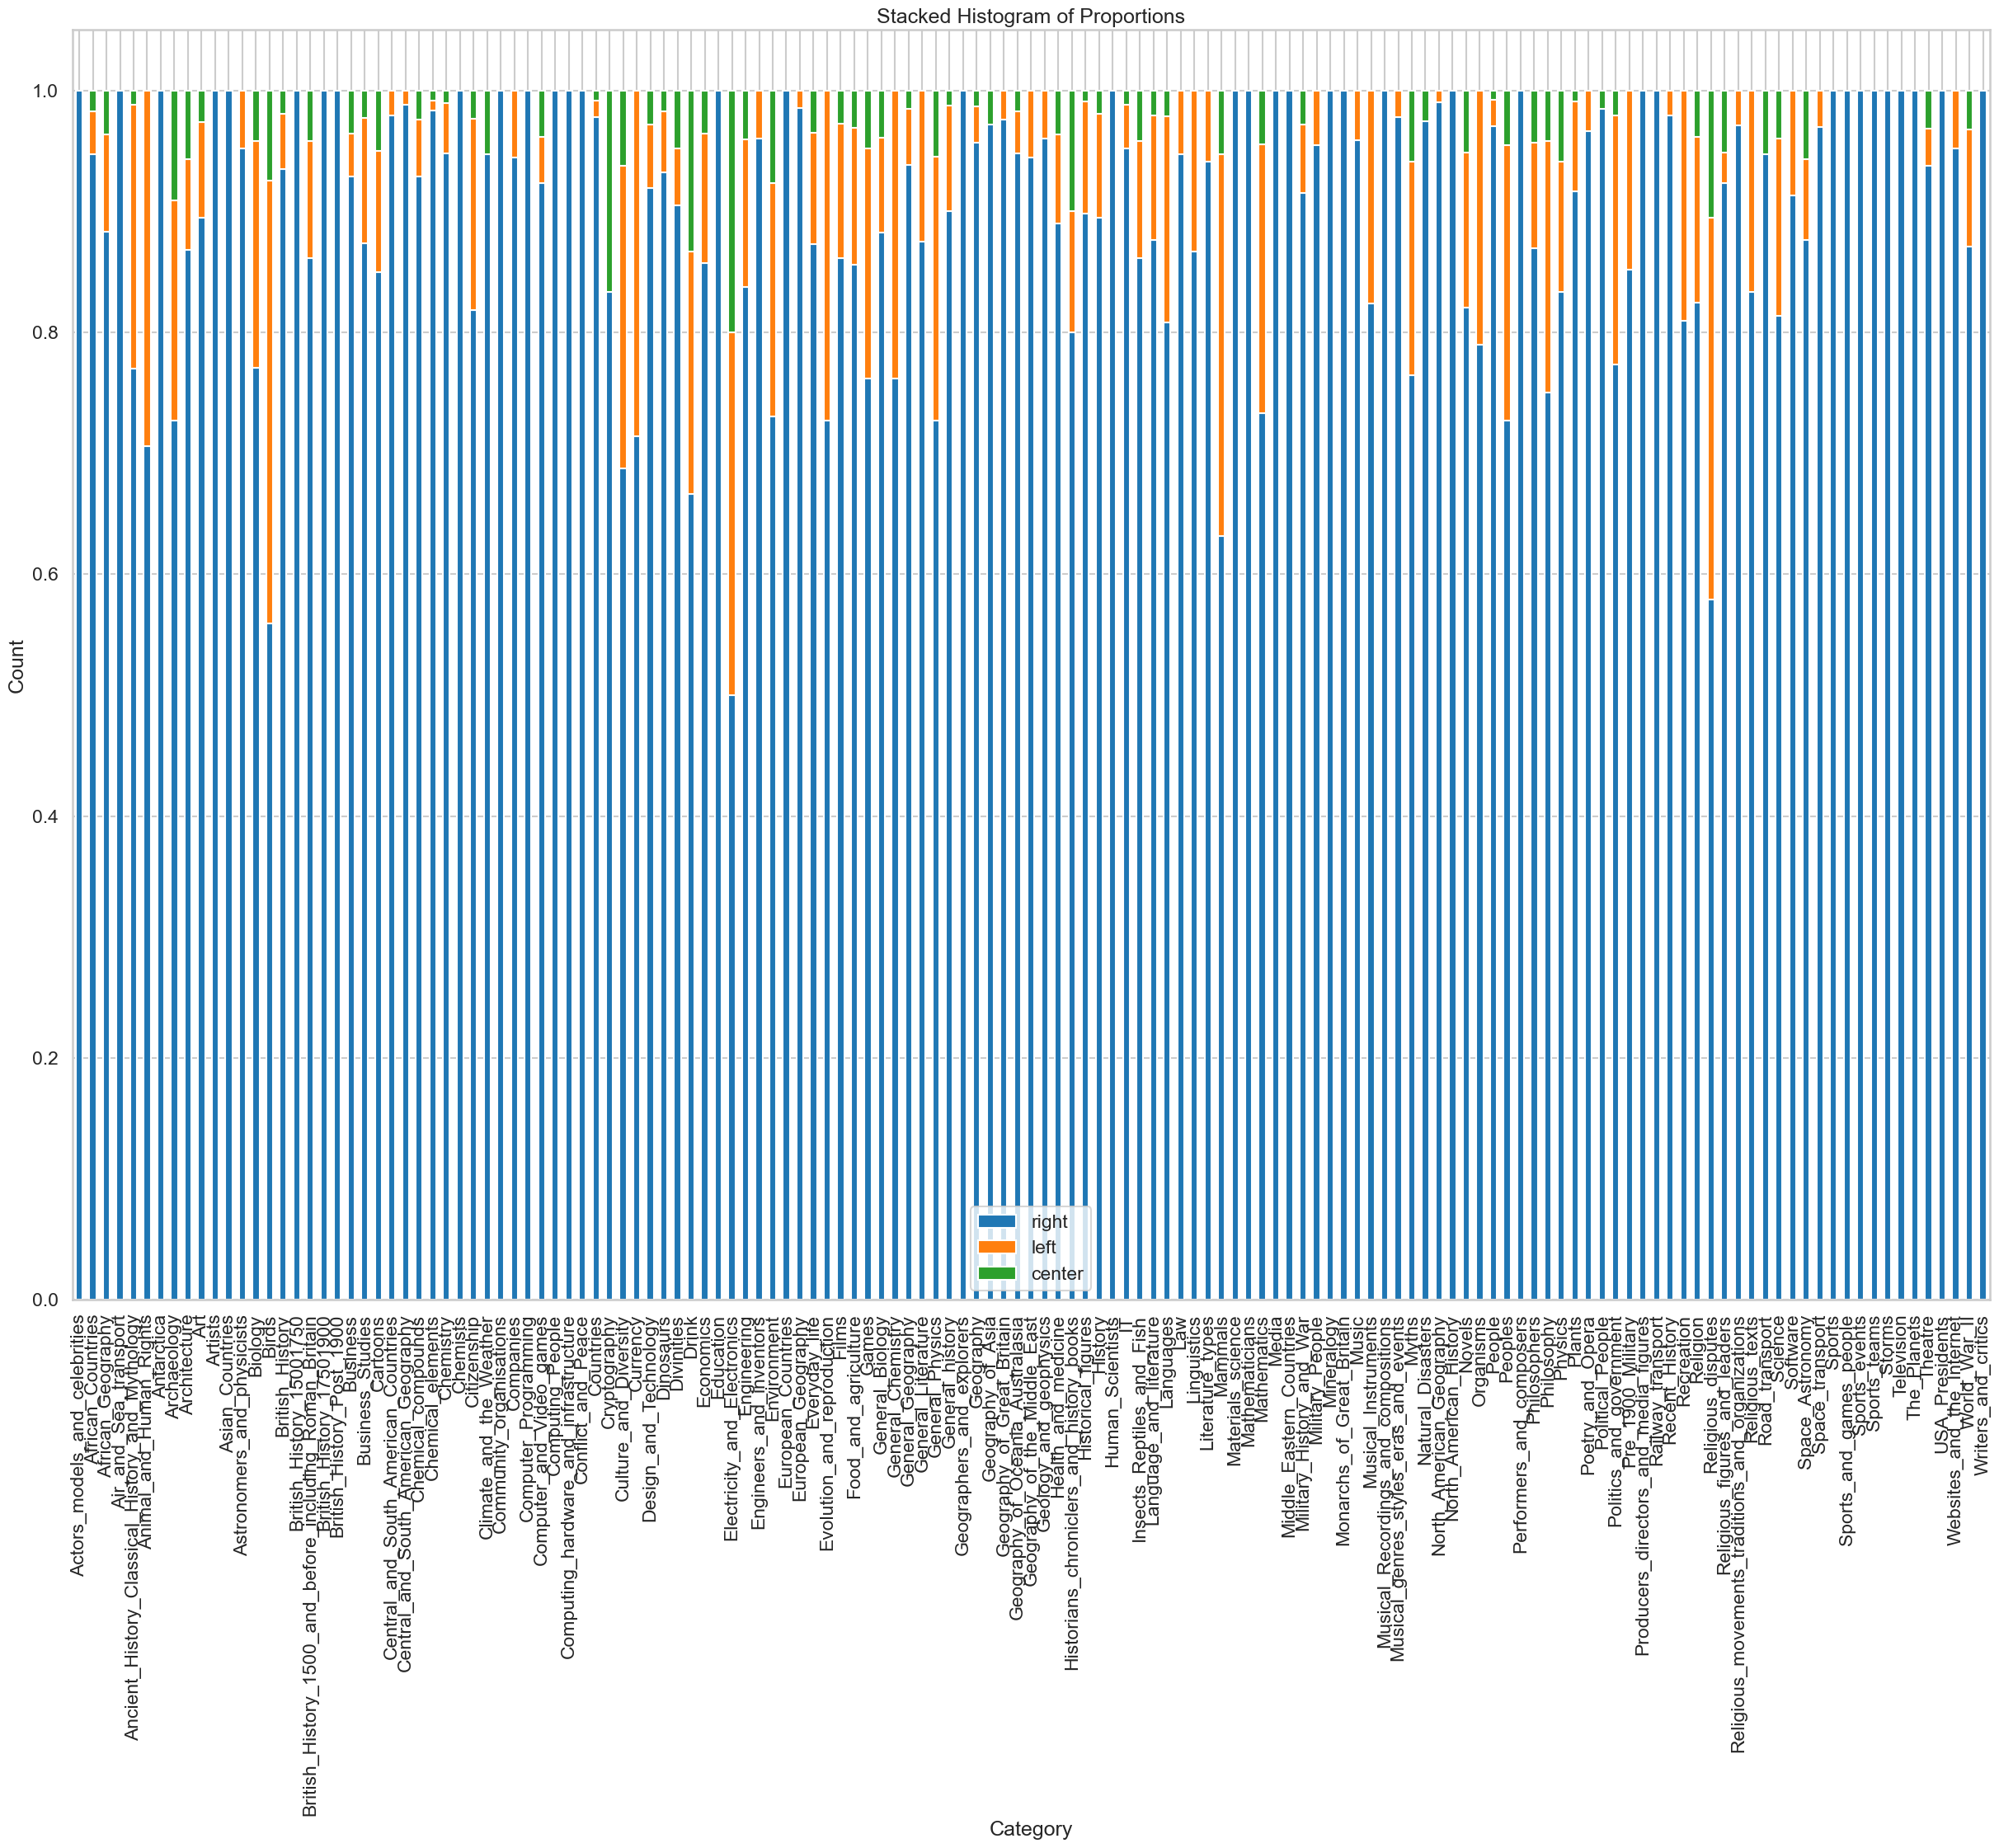

<Figure size 640x480 with 0 Axes>

In [89]:
all_articles_with_bias_and_categories.head()

df = all_articles_with_bias_and_categories.copy()

#test = all_articles_with_bias_and_categories.groupby([['bias',  '']])


df.columns
df.head()
right_df = df[df['Bias'] == 'right'].drop(columns=['article', 'Bias'])
right_df = right_df.sum()
right_df.name = 'right'
left_df = df[df['Bias'] == 'left'].drop(columns=['article', 'Bias'])
left_df = left_df.sum()
left_df.name ='left'

center_df = df[df['Bias'] == 'center'].drop(columns=['article', 'Bias'])
center_df = center_df.sum()
center_df.name = 'center'


right_df
plot_df = pd.merge(right_df, left_df, left_index=True, right_index=True, how='inner')
plot_df = pd.merge(plot_df, center_df, left_index=True, right_index=True, how='inner')
plot_df.head()

total_counts = plot_df.sum(axis=1)
proportions_df = plot_df.divide(total_counts, axis=0)

# Display the DataFrame with proportions
ax = proportions_df.plot(kind='bar', stacked=True, figsize=(30, 20))

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Stacked Histogram of Proportions')

# Display the plot
plt.show()
plt.tight_layout()

In [33]:
bias_counts = bias['Bias'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(bias_counts, labels=bias_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Political Bias repartition')
plt.axis('equal') 
plt.show()

TypeError: string indices must be integers

In [ ]:
categories = all_articles_with_bias_and_categories.drop(['article', 'Bias'], axis=1)
categories.head()

,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,Art,...,Sports_events,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


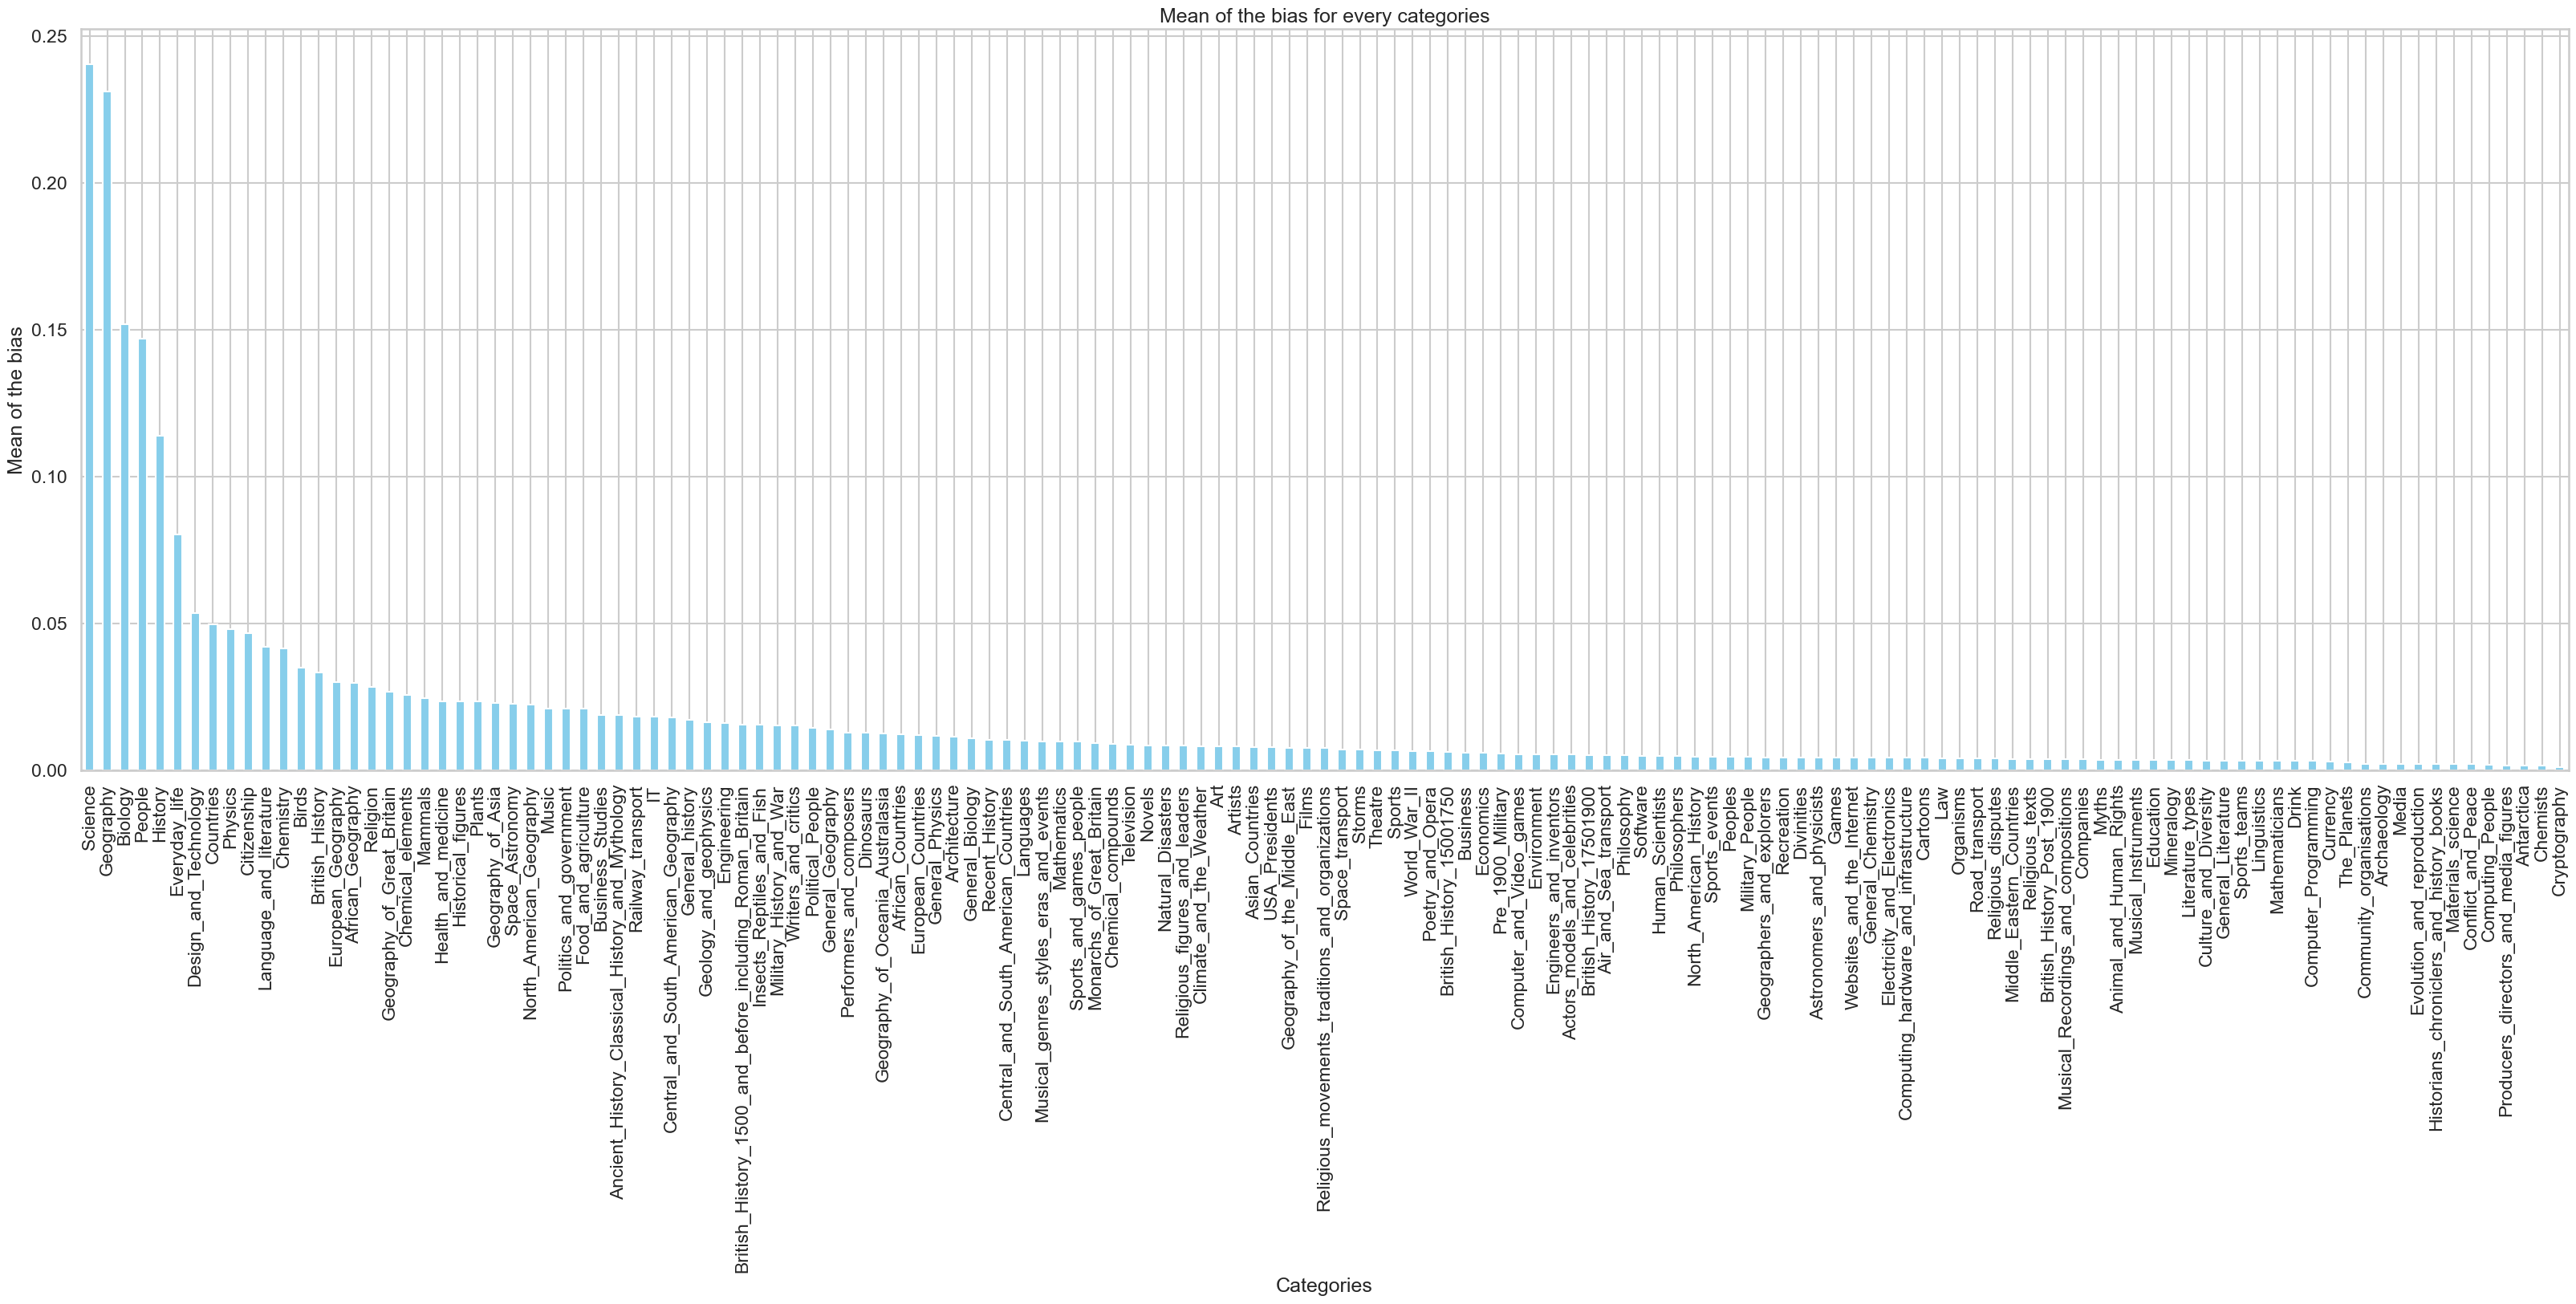

In [ ]:
categories.mean().sort_values(ascending=False).plot(kind='bar', figsize=(40, 12), color='skyblue')
plt.title('Mean of the bias for every categories')
plt.xlabel('Categories')
plt.ylabel('Mean of the bias')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_articles_with_bias_and_categories.head()

,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics,Bias
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right


In [ ]:
all_articles_with_bias_and_categories_transposed = all_articles_with_bias_and_categories.T

In [ ]:
# pick out the biases, could also be possible with the bias df 
biases = all_articles_with_bias_and_categories_transposed.iloc[-1]

category_to_articles_with_bias = {}

#iterate throughs every row except bias that is the last one --> :-1
for category in all_articles_with_bias_and_categories_transposed.index[:-1]:
    articles_in_category = all_articles_with_bias_and_categories_transposed.loc[category][all_articles_with_bias_and_categories_transposed.loc[category] == 1]
    articles_bias = biases[articles_in_category.index]
    articles_with_bias = list(zip(articles_in_category.index, articles_bias))
    category_to_articles_with_bias[category] = articles_with_bias

"""
for category, articles_with_bias in category_to_articles_with_bias.items():
    print(f"Catégorie : {category}")
    for article, bias in articles_with_bias:
        print(f"Article : {article}, Bias : {bias}")
    print("\n")
"""

'\nfor category, articles_with_bias in category_to_articles_with_bias.items():\n    print(f"Catégorie : {category}")\n    for article, bias in articles_with_bias:\n        print(f"Article : {article}, Bias : {bias}")\n    print("\n")\n'

AttributeError: 'str' object has no attribute 'head'

In [ ]:
space_trans_cat = category_to_articles_with_bias['Space_transport']

biases = [bias for _, bias in space_trans_cat]
bias_counts = {0: 0, 1: 0, 2: 0}
for _, bias in space_trans_cat:
    bias_counts[bias] += 1
    labels = ['Left', 'Center', 'Right']
sizes = [bias_counts[0], bias_counts[1], bias_counts[2]]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Bias repartition for the categories Space transport')
plt.show()

KeyError: 'right'

In [ ]:
for category, articles_with_bias  in category_to_articles_with_bias.items():
    biases = [bias for _, bias in articles_with_bias]
    bias_counts = {0: 0, 1: 0, 2: 0}
    for _, bias in articles_with_bias:
        bias_counts[bias] += 1
        labels = ['Left', 'Center', 'Right']
    sizes = [bias_counts[0], bias_counts[1], bias_counts[2]]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels)
    plt.title('Bias repartition for the categories Space transport')
    plt.show()  

c:\Users\Adrien\anaconda3\envs\envADA\lib\site-packages\matplotlib\axes\_axes.py:3193: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 800x800 with 1 Axes>